<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/dl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn in this notebook
 
1. Introduction to supervised learning and classification
1. Introduction to loss functions, activation functions, and gradient descent
1. Introduction to Pytorch packages, tensors, computation graphs, and gradients


## CIFAR10 Dataset

- We use the CIFAR10 dataset to perform binary classification

In [1]:
import torch 
import torchvision as vision

cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True)# train=True is the default
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### Data transforms
- Recall from last session that CIFAR10 contains a set of images/labels. To use the dataset with PyTorch we need to **transform** the data to tensors

In [2]:
itr=iter(cifar10_train)
img,label=next(itr)
print(type(img),type(label))

<class 'PIL.Image.Image'> <class 'int'>


In [3]:
from torchvision.transforms import ToTensor
cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=ToTensor())
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=ToTensor())
itr=iter(cifar10_train)
img,label=next(itr)
print(type(img))

Files already downloaded and verified
Files already downloaded and verified
<class 'torch.Tensor'>


### Binary classification

- The dataset has 10 classes: Airplanes,Cars,Birds,Cats,Deers,Dogs,Frogs,Horses, Ships and Trucks
- For simplicity we will rearrange it into only 2 classes
    - "Living things": Birds, Cats,Deers,Dogs, Frogs, Horses
    - "Machines": Airplanes, Cars, Shipts and Trucks

- Rearrange both the train and test datasets
- Why didn't we use ```label=1``` and ```label=0``` in the code below ?

In [4]:
#airplane=0,car=1,bird=2,cat=3,deer=4,dog=5,frog=6,horse=7,ship=8,truck=9
features=torch.tensor([0,1,8,9])
for i, (img,label) in enumerate(cifar10_train):
    if torch.isin(label,features):
        cifar10_train.targets[i]=1
    else:
        cifar10_train.targets[i]=0
for i, (img,label) in enumerate(cifar10_test):
    if torch.isin(label,features):
        cifar10_test.targets[i]=1
    else:
        cifar10_test.targets[i]=0

### Stochastic gradient descent

- So far the gradient was computed over the whole dataset
    - In many situations this is not feasible, e.g. not enough memory
- A good approximation is stochastic gradient descent
    - The gradient is computed for a single sample
- Another, most commonly used varient, is to compute the gradient over a random subset of the dataset (batch)
    - Saves memory
    - Better chance to escape local minima
- We will refer to the above version as stochastic gradient descent (SGD)

### Data loader
- SGD is more efficient when the batches are randomly selected
- PyTorch provides a convenient class for operations on batches: ```DataLoader```
- ```num_workers``` is the number of threads used for parallel processing

In [9]:
from torch.utils.data import DataLoader
batch_size=64
train_loader=DataLoader(cifar10_train,batch_size=batch_size,num_workers=2)
test_loader=DataLoader(cifar10_test,batch_size=batch_size,num_workers=2)

In [10]:
itr=iter(train_loader)
imgs,labels=next(itr)
print(type(imgs),labels.dtype)
print(imgs.shape,labels.shape)

<class 'torch.Tensor'> torch.int64
torch.Size([64, 3, 32, 32]) torch.Size([64])




## Logistic Regression

- Logistic Regression can be regarded as the **simplest neural network**, a single "neuron". 
- It takes as input a vector of size $n$ and it feeds a single unit (a neuron or perceptron). 
- The neuron is represented by a vector of **learnable** weights $w$ and bias $b$
- The output is the sum of $b$ and the **dot** product between $w$ and the vector input $x$
- The result is fed into some function (usually nonlinear) $f$ called the activation.



$$
\begin{align*}
z&=\sum_iw_i\cdot x_i+b\\
\hat{y}(x)&=f(z)
\end{align*}
$$

- Note that because $z$ depends on $W$ and $b$ so does $\hat{y}$. 
- Therefore our task is to **learn** the "best" values of $W$ and $b$ to model the data



- The input $x$ and $f$ are known whereas $w$ and $b$ are parameters to be determined. 
- Our goal is to find the _optimal_ $w$ and $b$ such that the output is as *close as possible* to the label associated with the input.
![title](https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/perceptron.png?raw=1)



- How is "**as close as possible**" defined? 
- The dataset is usually a set of pairs $(x,y)$. 
- We define the loss as the **deviation** between the label $y$ and the result $\hat{y}=f(z)$

$$loss=\mathcal{L}_{w,b}(y,\hat{y})$$

- The function $\mathcal{L}$ depends on the problem (for example binary cross entropy, mean squared error,...)

- Note that $\mathcal{L}$ depends on the parameters $w,b$. 
- Our goal is to find the **optimal** $w,b$ such that $\mathcal{L}$ is minimal. 

## Sigmoid

- So far we have not specified the function _f_ that our  model depends on $\hat{y}=f(z)$. 
- In this example we use the **sigmoid** function. Given an input _z_ it has the form

$$
\begin{align*}
\sigma=\frac{1}{1+e^{-z}}
\end{align*}
$$
- The values of $\sigma$ go from 0 to 1 which we interpret as the probability that the label is 1
- $1-\sigma$ is the probability that the label is 0


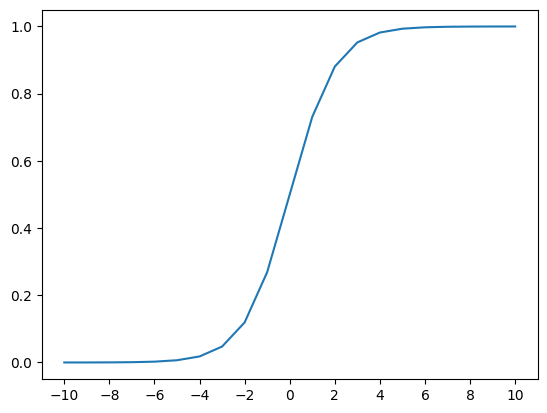

In [7]:
import numpy as np
import matplotlib.pyplot as plt
z=[1/(1+np.exp(-x)) for x in range(-10,11)]
plt.plot([x for x in range(-10,11)],z)
plt.xticks([t for t in range(-10,11,2)])
plt.show()

## Flatening the images
- The input images have dimensions (3,32,32) (3 channels, 32 height,32 width). 
- To use them as input to the "neuron" we need to "flatten" the input
- One can use the ```.reshape``` method

In [8]:
itr=iter(train_loader)
imgs,labels=next(itr)
rimgs=rimgs.reshape(batch_size,-1)
print(rimgs.shape,labels.shape)
torch.unique(labels)

torch.Size([32, 3072]) torch.Size([32])


tensor([0, 1])

- ```reshape``` does not work when the size of the datasets is **not** a multiple of the batch size
- For CIFAR10 there are 50000 training samples. 
- That's 781 batches of size 64 and the last has size 16: ```50000=781*64+16```

In [14]:
for batch in train_loader:
    imgs,labels=batch
    
print(imgs.shape,labels.shape)

torch.Size([16, 3, 32, 32]) torch.Size([16])


### use of ```flatten```

- It is more convenient to use ```tensor.flatten(start_dim=d)```
- Where ```d``` specifies from which dimension to start "flattening"

In [13]:
print(imgs.shape)
print(imgs.flatten(start_dim=0).shape,imgs.flatten(start_dim=1).shape)

torch.Size([64, 3, 32, 32])
torch.Size([196608]) torch.Size([64, 3072])


## Initialize the parameters
- The goal is tofind the **optimal** values for the parameters, $w$ and $b$. 
- Intially we give them random values (for weights) and 0 for the bias as shown below. 
- Note that
    - The `reguires_grad` declares a tensor to be a variable
    - In previous versions of Pytorch one needed to declare variables explicitly but this is deprecated now. See [here](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)

In [ ]:
weights=torch.randn(3*32*32,requires_grad=True,dtype=torch.float32)
bias=torch.tensor(0.,requires_grad=True,dtype=torch.float32)

## Optimization loop

In [ ]:
rate=0.015
loss_fn=torch.nn.BCELoss()
epochs=10
for epoch in range(epochs):
    for imgs,labels in train_loader:
        imgs=imgs.flatten(start_dim=1)
        y_hat=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(y_hat)
        loss=loss_fn(y_hat,labels.float())
        dw,db=torch.autograd.grad(loss,[weights,bias])
        #update the weights and bias
        weights.data-=rate*dw
        bias.data-=rate*db

  
    print("loss {:.4f}".format(loss.item()))

## Prediction on the test data

- An important measure of any ML method is how well it "generalizes". 
- This is done by using the trained model on **test** data, i.e. data that it **was not** trained on 
- But he output of our model is the probability that the input is a "machine", which could be any value between 0 and 1. 
- The test labels are discrete values of 0 and 1 so how do we compare them? 
- We regard a probability $\ge 0.5$ to be 1 and $< 0.5$ to be 0

### Measuring accuracy

In [ ]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        imgs=imgs.flatten(start_dim=1)
        y_hat=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(y_hat)
        ones=y_hat>0.5
        ## count how many outputs are equal to the "true" labels
        r=ones==labels
        ## add them to the total
        total+=r.sum()
    
    return total/len(loader.dataset)

In [ ]:
predict(test_loader)

## Abstracting the model and training pipeline using Pytorch

- The model we have used  is simple enough to code directly. 
- We only needed Pytorch to compute the loss and gradients. 
- For more complicated models this process becomes unwieldy. 
- We can use Pytorch to abstract away the details.  
- The abstractions offered by Pytorch are illustrated below to solve the same problem that we just did. 

### The model

- The model we plan to use is encapsulated in a class that **inherits** from ```torch.nn.Module```

- All we need to do is **override** two methods:
1. ```__init__```. As you would have guessed this is called when the object is constructed to initialize our model
1. ``` forward```. This is called to perform a forward computation

In [ ]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self,in_features,out_features):
    super(Net, self).__init__()
    self.input_size=in_features
    self.output_size=out_features
    # declaring weights and bias as parameters so that they are included
    # in the return value of .parameters()
    self.weights=nn.Parameter(torch.randn(in_features,requires_grad=True,dtype=torch.float32))
    self.bias=nn.Parameter(torch.tensor(0.,requires_grad=True,dtype=torch.float32))
    #self.layer=nn.Linear(self.input_size,self.output_size,bias=True)
  def forward(self,input):  
    y_hat=input.flatten(start_dim=1)
    y_hat=torch.matmul(y_hat,self.weights)+self.bias
    y_hat=torch.sigmoid(y_hat)
    return y_hat

- Note that in the initialization, the weights and bias are constructed as ```Parameter```. 
- This is so that we can use the ```.parameters()``` call and pass it to the optimizer.
- Next we create an instance of the model

In [ ]:
model=Net(3*32*32,1)

Recall that each learning iteration performs a number of steps. 
1. Compute the forward pass over the input to get the output. This is now done using ```model.forward()``` indirectly by calling ```model(input)```
1. Compute the loss using an appropriate loss function. Same as before
1. Compute the gradients using ```loss.backward()```.
    


- ```backward()``` computes the gradient with respect to the parameters AND saves them in the ```.grad``` attributes
- For example, if ```p``` is a parameters then ```loss.backward()``` computes the gradient of ```loss``` wrt ```p``` AND saves the result in ```p.grad```
- Once the gradients are computed
1. The optimizer updates the parameters. 
    - This is done by the optimizer using ```optimizer.step()```. 
1. This is important since later on we will use optimizers that use a different strategy to update the parameters.

In [ ]:
rate=0.015

import torch.optim as optim
optimizer=optim.SGD(model.parameters(),lr=rate)
loss_fn=torch.nn.BCELoss()
epochs=10
for epoch in range(epochs):
  for imgs,labels in train_loader:
  # uses the .forward() method to get y_hat
    y_hat=model(imgs)
  # as before
    loss=loss_fn(y_hat,labels.float())
  # Computes the gradients and saves them in the appropriate .grad
    loss.backward()
  # updates the parameters using the computed .grad
    optimizer.step()
  # zero the .grad values so that they don't accumulate
    optimizer.zero_grad()
  
  print("loss {:.4f}".format(loss.item()))

In [ ]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        outputs=model(imgs)
        ones=outputs>0.5
        r=ones==labels
        total+=r.sum()
    # Compute vector "y_hat" predicting
    # the probabilities of a machine being present in the picture
    
    return total/len(loader.dataset)

In [ ]:
predict(test_loader)